In [25]:
#@title Imports and Utility Functions

import json
import numpy as np
import matplotlib.pyplot as plt
import pprint

def best_response(merge_number, price_grid, data, trial, memory_type):
  action = np.zeros((2,15))
  if memory_type == "decay_incremental_merge_from_bottom":
    for i in range(15):
      if i != 0 and i < merge_number:
        continue
      else:
        action[0][i] = price_grid[np.argmax(data[trial]["1"][i])]
        action[1][i] = price_grid[np.argmax(data[trial]["2"][i])]
    return action
  if memory_type == "decay_incremental_merge_from_top":
    threshold = 15 - merge_number
    for i in range(15):
      if i != 14 and i >= threshold:
        continue
      else:
        action[0][i] = price_grid[np.argmax(data[trial]["1"][i])]
        action[1][i] = price_grid[np.argmax(data[trial]["2"][i])]
    return action
  if memory_type == "decay_threshold_fixed":
    for i in range(15):
      if i==0:
        action[0][i] = price_grid[np.argmax(data[trial]["1"][i])]
        action[1][i] = price_grid[np.argmax(data[trial]["2"][i])]
      elif i == 14:
        action[0][i] = price_grid[np.argmax(data[trial]["1"][i])]
        action[1][i] = price_grid[np.argmax(data[trial]["2"][i])]
      else:
        continue
    return action

def memory_map(memory_type, index, merge_number):
  if memory_type == "decay_incremental_merge_from_bottom":
    return 0 if index < merge_number else index
  if memory_type == "decay_incremental_merge_from_top":
    return 14 if index >= 15-merge_number else index
  if memory_type == "decay_threshold_fixed":
    return 0 if index < merge_number else 14

'''
This function follows the cycles of the action starting from the fully-collusive price pair.
'''
def follow_the_cycles(merge_number, price_grid, data, trial):
  # Compute the argmax actions corresponding to each state
  action = best_response(merge_number, price_grid, data, trial, MEMORY_TYPE)

  loop = []
  a,b = price_grid[14], price_grid[14]
  while [a,b] not in loop:
    loop.append([a,b])
    i = memory_map(MEMORY_TYPE, np.where(price_grid == b)[0][0], merge_number)
    j = memory_map(MEMORY_TYPE, np.where(price_grid == a)[0][0], merge_number)
    a = price_grid[np.argmax(data[trial]["1"][i])]
    b = price_grid[np.argmax(data[trial]["2"][j])]
  loop.append([a,b])
  loop_new = [x for x in loop]
  for i, x in enumerate(loop):
    if [a,b] != x:
      loop_new.remove(x)
    else:
      break
  return [x[0] for x in loop_new], [x[1] for x in loop_new]


def profit_computer_with_errors(merge_number, price_grid, data, trials):

  profit_list = []
  for trial in range(trials):
    loop1, loop2 = follow_the_cycles(merge_number, price_grid, data, trial)
    mu = np.ones(2)*0.25
    q = np.ones(2)*2.0
    costs = np.ones(2)*1.0
    profit = []
    for i in range(len(loop1)):
      prices = [loop1[0], loop2[0]]
      exp_quantities = np.exp((q-prices)/mu)
      quantities = exp_quantities/sum(exp_quantities)

      profit.append((prices - costs) * quantities)
    profit_list.append((np.mean([x[0] for x in profit]) + np.mean([x[1] for x in profit]))/2)

  mean = np.mean(profit_list)
  ste = np.std(profit_list, ddof=1)/np.sqrt(len(profit_list))
  return mean, ste

def profit_computer(merge_number, price_grid, data, trials):
  sum_profit = 0
  for trial in range(trials):
    loop1, loop2 = follow_the_cycles(merge_number, price_grid, data, trial)
    mu = np.ones(2)*0.25
    q = np.ones(2)*2.0
    costs = np.ones(2)*1.0
    profit = []
    for i in range(len(loop1)):
      prices = [loop1[0], loop2[0]]
      exp_quantities = np.exp((q-prices)/mu)
      quantities = exp_quantities/sum(exp_quantities)

      profit.append((prices - costs) * quantities)
    sum_profit += np.mean([x[0] for x in profit])
    sum_profit += np.mean([x[1] for x in profit])

  return sum_profit/(2*trials)

def profit_computer_only_above_nash(merge_number, price_grid, data, trials):
  sum_profit = 0
  profit_list = []
  for trial in range(trials):
    loop1, loop2 = follow_the_cycles(merge_number, price_grid, data, trial)
    mu = np.ones(2)*0.25
    q = np.ones(2)*2.0
    costs = np.ones(2)*1.0
    profit = []
    for i in range(len(loop1)):
      prices = [loop1[0], loop2[0]]
      exp_quantities = np.exp((q-prices)/mu)
      quantities = exp_quantities/sum(exp_quantities)
      profit.append((prices - costs) * quantities)

    if np.mean([x[0] for x in profit]) >= 0.26 and np.mean([x[1] for x in profit]) >= 0.26:
      profit_list.append((np.mean([x[0] for x in profit]) + np.mean([x[1] for x in profit]))/2)

  if len(profit_list) == 0:
    return 0, 0
  mean = np.mean(profit_list)
  ste = np.std(profit_list, ddof=1)/np.sqrt(len(profit_list))
  return mean, ste


def profit_computer_only(prices, price_grid):
  mu = np.ones(2)*0.25
  q = np.ones(2)*2.0
  costs = np.ones(2)*1.0
  profit = []
  exp_quantities = np.exp((q-prices)/mu)
  quantities = exp_quantities/sum(exp_quantities)
  profit= (prices - costs) * quantities
  return profit

def profit_matrix(price_grid):
  """
  Calculates a profit matrix where entry (i, j) represents the profit of
  firm 1 when its price is price_grid[i] and the opponent's price is price_grid[j].

  Args:
    price_grid: A 1D numpy array of possible prices.

  Returns:
    A 2D numpy array representing the profit matrix.
  """

  mu = 0.25  # Assuming mu is the same for both firms
  q = 2.0    # Assuming q is the same for both firms
  costs = 1.0

  num_prices = len(price_grid)
  profit_matrix = np.zeros((num_prices, num_prices))

  for i in range(num_prices):
    for j in range(num_prices):
      prices = np.array([price_grid[i], price_grid[j]])
      exp_quantities = np.exp((q - prices) / mu)
      quantities = exp_quantities / np.sum(exp_quantities)
      profit_matrix[i, j] = (prices[0] - costs) * quantities[0]

  return profit_matrix



profits_per_memory_type = {}
error_bars_per_memory_type = {}

In [29]:
# @title <text>
# @markdown This cell runs the code for all the simulations present. It frees memory afterwards, so it doesn't allow access to data from the simulation.

MEMORY_TYPE = 'decay_threshold_fixed' # @param [ "incremental_merge_from_bottom", "decay_incremental_merge_from_bottom", "decay_incremental_merge_from_top", "decay_threshold_fixed"]
folder = "data_egreedy_firstrun" # @param [ "data_egreedy_firstrun", ""]

price_grid = np.zeros(15)
increment =  (1.97  - 1.43)/14
for i in range(15):
  price_grid[i] = np.around(1.43 + i*increment, 2)

profits_per_memory_type = {}
error_bars_per_memory_type = {}
for merge_number in range(14):
  merge_number +=1
  try:
    filename = 'simplicity/' + folder + '/data_' + MEMORY_TYPE + '_' + str(merge_number) + '.json'
    f = open(filename)
    data = json.loads(json.load(f))
    profit, error = profit_computer_with_errors(merge_number, price_grid, data, 10)
    profits_per_memory_type[merge_number] = profit
    error_bars_per_memory_type[merge_number] = error
  except:
    print("whoops, missing {}".format(merge_number))
    pass

profits_per_memory_type_only_above_nash = {}
error_bars_per_memory_type_only_above_nash = {}
for merge_number in range(14):
  merge_number +=1
  try:
    filename = 'simplicity/' + folder + '/data_' + MEMORY_TYPE + '_' + str(merge_number) + '.json'
    f = open(filename)
    data = json.loads(json.load(f))
    profit, errors = profit_computer_only_above_nash(merge_number, price_grid, data, 10)

    profits_per_memory_type_only_above_nash[merge_number] = profit
    error_bars_per_memory_type_only_above_nash[merge_number] = errors
  except:
    print("whoops, missing {}".format(merge_number))
    pass


/google/bin/releases/colaboratory/public/mpm/live/notebook_py3/colab/google3/third_party/py/numpy/_core/_methods.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
/google/bin/releases/colaboratory/public/mpm/live/notebook_py3/colab/google3/third_party/py/numpy/_core/_methods.py:219: RuntimeWarning: invalid value encountered in scalar divide


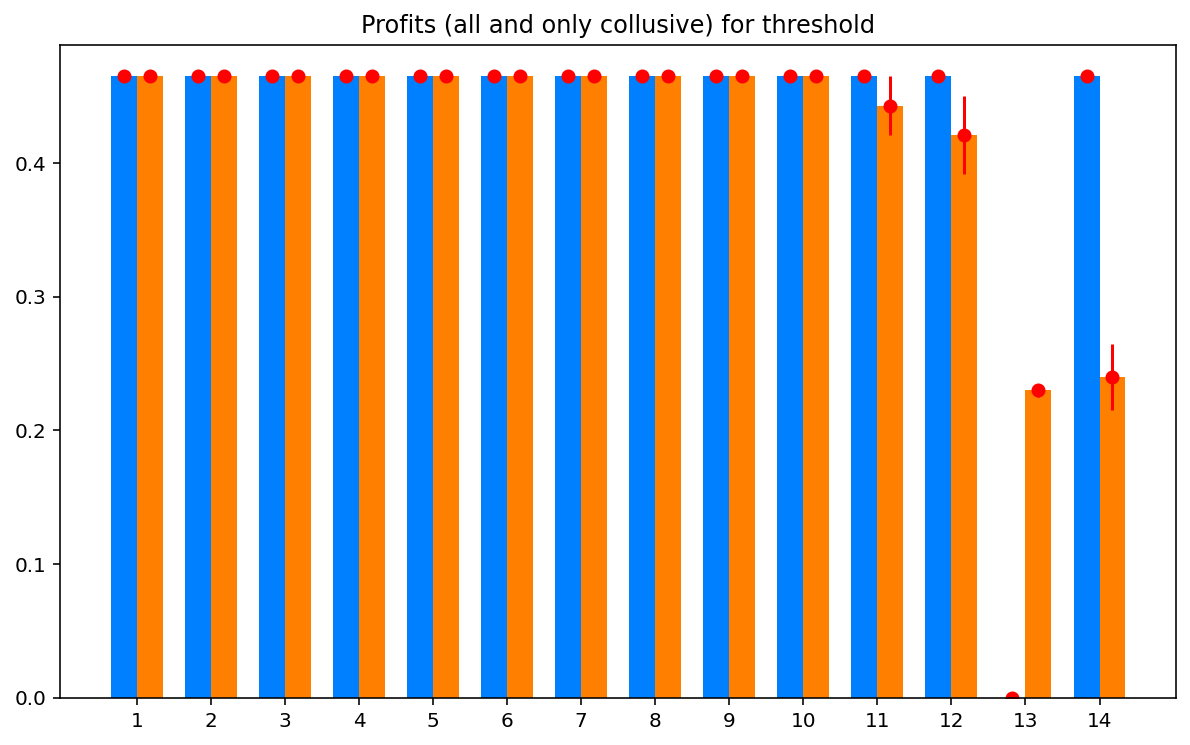

In [30]:
# @title Plot

# @markdown In blue we have the bars for profits only above Nash. In orange we have the general averaged out bars.

# @markdown When orange bars are below the blue bars, the algorithms sometimes learn Nash (or worse) which brings the average profit down.
profits_per_memory_type = dict(sorted(profits_per_memory_type.items()))
error_bars_per_memory_type = dict(sorted(error_bars_per_memory_type.items()))
profits_per_memory_type_only_above_nash = dict(sorted(profits_per_memory_type_only_above_nash.items()))
error_bars_per_memory_type_only_above_nash = dict(sorted(error_bars_per_memory_type_only_above_nash.items()))

# Combine the data for plotting
bar_width = 0.35
index = np.arange(len(profits_per_memory_type))

plt.figure(figsize=(10, 6))

# Plot the first set of data with blue bars
plt.bar(index,
        list(profits_per_memory_type_only_above_nash.values()),
        bar_width,
        color='#0080FF',
        label='Only Above Nash')
plt.errorbar(index,
             list(profits_per_memory_type_only_above_nash.values()),
             yerr=list(error_bars_per_memory_type_only_above_nash.values()),
             fmt="o",
             color='r')

# Plot the second set of data with red bars, offsetting the x position
plt.bar(index + bar_width,
        list(profits_per_memory_type.values()),
        bar_width,
        color='#FF8000',
        label='With Errors')
plt.errorbar(index + bar_width,
             list(profits_per_memory_type.values()),
             yerr=list(error_bars_per_memory_type.values()),
             fmt="o",
             color="r")

plt.xticks(index + bar_width / 2, list(profits_per_memory_type.keys()))
#plt.legend()
title = MEMORY_TYPE.split('_')
if title[1] == 'incremental':
  title = title[4]
elif title[1] == 'threshold':
  title = title[1]
else:
  title = "type unknown"
plt.title(f"Profits (all and only collusive) for {title}")
plt.show()

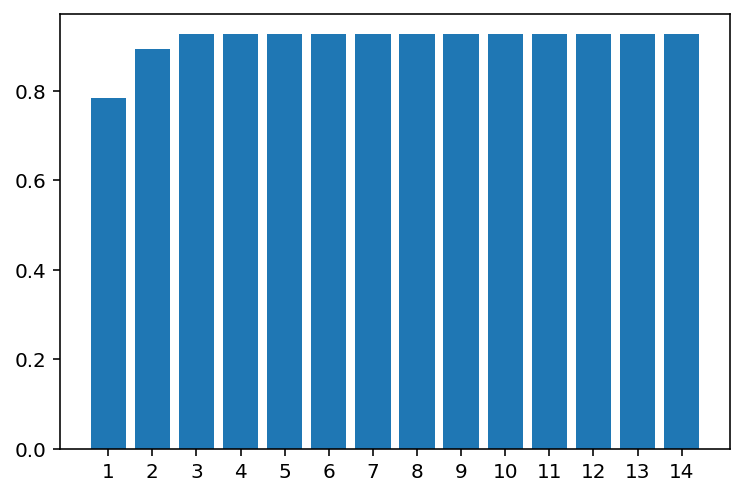

In [45]:
# @title <text>
def lowest_profit():
  mu = np.ones(2)*0.25
  q = np.ones(2)*2.0
  costs = np.ones(2)*1.0
  lowest_prices = [price_grid[0], price_grid[0]]
  exp_quantities = np.exp((q-lowest_prices)/mu)
  quantities = exp_quantities/sum(exp_quantities)
  profit = (lowest_prices - costs) * quantities
  return profit[0]

def highest_profit():
  mu = np.ones(2)*0.25
  q = np.ones(2)*2.0
  costs = np.ones(2)*1.0
  highest_prices = [price_grid[14], price_grid[14]]
  exp_quantities = np.exp((q-highest_prices)/mu)
  quantities = exp_quantities/sum(exp_quantities)
  profit = (highest_prices - costs) * quantities
  return profit[0]

def normalizer(x):
  return (x - lowest_profit()) / (highest_profit() - lowest_profit())

plt.bar(range(len(profits_per_memory_type)), [normalizer(x) for x in list(profits_per_memory_type.values())], align='center')
plt.xticks(range(len(profits_per_memory_type)), list(profits_per_memory_type.keys()))
plt.show()

In [4]:
#@title Structure of the game

#@markdown This is the payoff matrix of each player.

profit_mat = profit_matrix(price_grid)

np.set_printoptions(precision=2, suppress=True, linewidth=100)  # Adjust options as needed

print("The price grid is ", price_grid)
print("\n")
print(profit_mat)


The price grid is  [1.43 1.47 1.51 1.55 1.58 1.62 1.66 1.7  1.74 1.78 1.82 1.85 1.89 1.93 1.97]


[[0.21 0.23 0.25 0.27 0.28 0.29 0.31 0.32 0.33 0.34 0.36 0.36 0.37 0.38 0.39]
 [0.22 0.23 0.25 0.27 0.29 0.3  0.32 0.34 0.35 0.36 0.38 0.39 0.4  0.41 0.41]
 [0.21 0.23 0.26 0.28 0.29 0.31 0.33 0.35 0.36 0.38 0.4  0.41 0.42 0.43 0.44]
 [0.21 0.23 0.25 0.28 0.29 0.31 0.33 0.36 0.37 0.39 0.41 0.42 0.44 0.45 0.46]
 [0.21 0.23 0.25 0.27 0.29 0.31 0.34 0.36 0.38 0.4  0.42 0.43 0.45 0.47 0.48]
 [0.2  0.22 0.24 0.27 0.29 0.31 0.33 0.36 0.38 0.41 0.43 0.44 0.46 0.48 0.5 ]
 [0.19 0.21 0.23 0.26 0.28 0.3  0.33 0.36 0.38 0.41 0.43 0.45 0.47 0.49 0.51]
 [0.18 0.2  0.22 0.25 0.27 0.29 0.32 0.35 0.38 0.41 0.43 0.45 0.48 0.5  0.52]
 [0.17 0.19 0.21 0.24 0.26 0.28 0.31 0.34 0.37 0.4  0.43 0.45 0.48 0.5  0.53]
 [0.15 0.18 0.2  0.22 0.24 0.27 0.3  0.33 0.36 0.39 0.42 0.44 0.47 0.5  0.53]
 [0.14 0.16 0.18 0.21 0.23 0.25 0.28 0.31 0.34 0.38 0.41 0.43 0.47 0.5  0.53]
 [0.13 0.15 0.17 0.2  0.22 0.24 0.27 0.3  0.

In [21]:
#@title Best-Response Functions and other Statistics of Individual Simulations


MEMORY_TYPE = 'decay_threshold_fixed' # @param [ "incremental_merge_from_bottom", "decay_incremental_merge_from_bottom", "decay_incremental_merge_from_top", "decay_threshold_fixed"]
folder = "data_egreedy_firstrun" # @param [ "data_egreedy_firstrun", ""]
merge_number = "14" #@param [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14] {allow-input:true}
simulation_number = "6" #@param [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] {allow-input:true}
simulation_number = int(simulation_number) -1
filename = 'simplicity/' + folder + '/data_' + MEMORY_TYPE + '_' + merge_number + '.json'

merge_number = int(merge_number)

# Open and read the JSON file
f = open(filename)

data = json.loads(json.load(f))

print("Each entry is the best-response of player 1 for a given price of player 2.")
print("\n")
print(", ".join(str(item) + " " if len(str(item)) <=3 else str(item) for item in price_grid))
print(", ".join(str(item) + " " if len(str(item)) <=3 else str(item) for item in best_response(merge_number, price_grid, data, simulation_number, MEMORY_TYPE)[1]))
print("\n")
print("Each entry is the best-response of player 2 for a given price of player 1")
print("\n")
print(", ".join(str(item) + " " if len(str(item)) <=3 else str(item) for item in price_grid))
print(", ".join(str(item) + " " if len(str(item)) <=3 else str(item) for item in best_response(merge_number, price_grid, data, simulation_number, MEMORY_TYPE)[1]))

Each entry is the best-response of player 1 for a given price of player 2.


1.43, 1.47, 1.51, 1.55, 1.58, 1.62, 1.66, 1.7 , 1.74, 1.78, 1.82, 1.85, 1.89, 1.93, 1.97
1.43, 0.0 , 0.0 , 0.0 , 0.0 , 0.0 , 0.0 , 0.0 , 0.0 , 0.0 , 0.0 , 0.0 , 0.0 , 0.0 , 1.43


Each entry is the best-response of player 2 for a given price of player 1


1.43, 1.47, 1.51, 1.55, 1.58, 1.62, 1.66, 1.7 , 1.74, 1.78, 1.82, 1.85, 1.89, 1.93, 1.97
1.43, 0.0 , 0.0 , 0.0 , 0.0 , 0.0 , 0.0 , 0.0 , 0.0 , 0.0 , 0.0 , 0.0 , 0.0 , 0.0 , 1.43


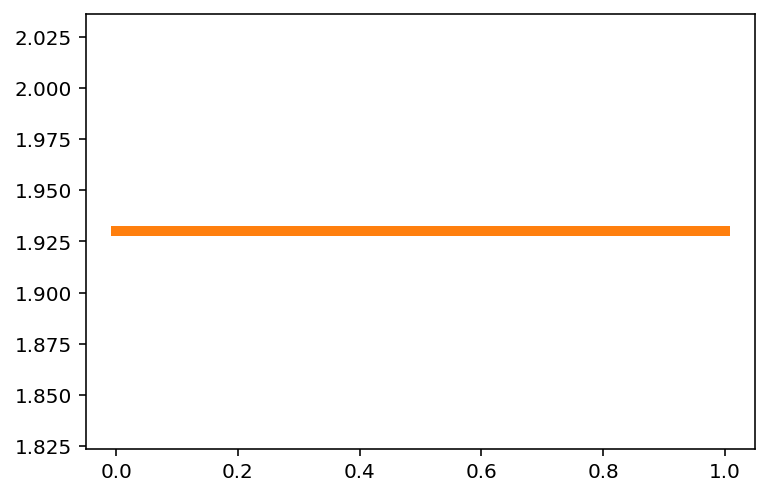

In [25]:
#@title Plotting the cycles
trial = 6

loop1, loop2 = follow_the_cycles(merge_number, price_grid, data, trial)
xs = [x for x in range(len(loop1))]

plt.plot(xs, loop1, linewidth = 5)
plt.plot(xs, loop2, linewidth = 5)
plt.show()